In [1]:
#from scripts.build_poincare_map.poincare_maps import *
#Load dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')
import scipy


#Import visualization functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
%matplotlib inline
from poincare_maps import *
from embedding_quality_score import *

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA


from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import plotly.express as px
import umap

In [2]:
from scripts.build_poincare_map.kmedoids import *
from sklearn import metrics

def get_scores(t_labels, labels):
    ARS = metrics.adjusted_rand_score(t_labels, labels)
    FMS = metrics.fowlkes_mallows_score(t_labels, labels)
    
    return ARS, FMS

def detect_cluster(D, n_clusters=2, clustering_name='spectral', k=5): #distances='Poincaré',
    if clustering_name == 'spectral':
        similarity = np.exp(-D**2)
        clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', 
                                        affinity='precomputed', n_neighbors=k).fit(similarity)
        labels = clustering.labels_
    elif clustering_name == 'kmedoids':
        clustering = kMedoids(D, n_clusters, tmax=10000)
        labels = clustering
    else:
        clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
                                             affinity='precomputed').fit(D)
        labels = clustering.labels_
            
    return labels


def color_clusters(df, x, y, color):
    plt = px.scatter(df_tsne, x = x, y = y,
                     color = color,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title
                 )
    fig.show()

In [3]:
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 1

out_name = "thioredoxins_data"
path_annotation = "examples/thioredoxins/thioredoxin_annotation_new1.csv"
path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
print(df_embedding)
df_embedding.replace("Other", "OTHER")

            proteins_id       pm1       pm2 Unnamed: 0      Species   Kingdom  \
proteins_id                                                                     
1                     1  0.183893  0.108609          0         LBCA      LBCA   
2                     2  0.111038 -0.141715          1         LACA      LACA   
3                     3  0.050593 -0.098363          2         AECA      AECA   
4                     4  0.313914  0.437660          3        LGPCA     LGPCA   
5                     5 -0.633037 -0.001717          4         LECA      LECA   
...                 ...       ...       ...        ...          ...       ...   
206                 206  0.868353 -0.141709        205  Escherichia  Bacteria   
207                 207  0.860335 -0.148330        206     Shigella  Bacteria   
208                 208  0.847628 -0.142849        207   Salmonella  Bacteria   
209                 209  0.865296 -0.160147        208     Yersinia  Bacteria   
210                 210  0.8

,proteins_id,pm1,pm2,Unnamed: 0,Species,Kingdom,Family,Color_eukaryota,Domain,Kingdom2,Phylum,Class
proteins_id,,,,,,,,,,,,
1,1,0.183893,0.108609,0,LBCA,LBCA,LBCA,OTHERS,LBCA,LBCA,LBCA,LBCA
2,2,0.111038,-0.141715,1,LACA,LACA,LACA,OTHERS,LACA,LACA,LACA,LACA
3,3,0.050593,-0.098363,2,AECA,AECA,AECA,OTHERS,AECA,AECA,AECA,AECA
4,4,0.313914,0.437660,3,LGPCA,LGPCA,LGPCA,OTHERS,LGPCA,LGPCA,LGPCA,LGPCA
5,5,-0.633037,-0.001717,4,LECA,LECA,LECA,OTHERS,LECA,LECA,LECA,LECA
...,...,...,...,...,...,...,...,...,...,...,...,...
206,206,0.868353,-0.141709,205,Escherichia,Bacteria,Proteobacteria,OTHERS,Bacteria,Bacteria,Proteobacteria,Gammaproteobacteria
207,207,0.860335,-0.148330,206,Shigella,Bacteria,Proteobacteria,OTHERS,Bacteria,Bacteria,Proteobacteria,Gammaproteobacteria
208,208,0.847628,-0.142849,207,Salmonella,Bacteria,Proteobacteria,OTHERS,Bacteria,Bacteria,Proteobacteria,Gammaproteobacteria


Labels and number of clusters:

In [ ]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
print(path_embedding)
model = PoincareMaps(poincare_coord)
model.get_distances()

# Comparison of different scores for Poincaré vs other methods

## Thioredoxins

In [4]:
n_proteins = df_embedding.shape[0]
x = np.array(np.loadtxt(out_name + "/fasta0.9/1.aamtx").reshape(-1))
len_prot = len(x)

features = np.zeros([n_proteins, len_prot])

for i in range(n_proteins):
    #print(out_name + "/fasta0.9/" + str(i) + ".aamtx")
    x = np.array(np.loadtxt(out_name + "/fasta0.9/" + str(i+1) + ".aamtx").reshape(-1))
    features[i,:] = x


In [5]:
D_raw = pairwise_distances(features, metric="cosine")
print(features[0,:])
print(D_raw.shape)

[0.0716 0.0078 0.073  ... 0.0105 0.0456 0.0274]
(210, 210)


In [6]:
# Construction of custom color palette 
globin_palette = {'Echinodermata': '#086b75', 'Arthropoda': '#0b237c', 'Mollusca': '#512ff8', 'Annelida': '#a191f3', 'Chordata': '#26c9d9', 'Cnidaria': '#ad288b', 'Porifera': '#fdb7fd', 'Placozoa': '#e9bd6b', 'Bacteria': '#f10000', 'Nematoda': '#5d78e3', 'Hemichordata': '#b0ffe8', 'Fungi': '#a0e361', 'Viridiplantae': '#4d9b03'}

## Evaluate clustering

In [21]:
df_results_clust = pd.DataFrame()

In [42]:
#true_col = "small_cluster"
true_col = "Family"
other = "OTHERS"
remove_others = True
remove_outliers = True

othersplus = ["LECA", "LBCA", "LPBCA", "AECA", "LGPCA", "LACA", "LAFCA"]

#print(df_embedding.shape)
#print(df_embedding[true_col].value_counts())

expected_nc = df_embedding[true_col].unique().size
no_outliers = df_embedding[true_col].duplicated(keep=False)

nc = expected_nc
print("Number of expected classes: ", nc)
k_neigh = knn


Number of expected classes:  28


In [43]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # poincare scores
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    D = pairwise_distances(X_mds)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    D = pairwise_distances(X_tsne)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    D = pairwise_distances(X_umap)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    D = pairwise_distances(X_pca)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = df_results_clust.append(df)
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = df_results_proj.append(df)

#print(df_results)

Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3


In [62]:
df_results_clust = df_results_clust[df_results_clust.true_col!="Family"]

In [69]:
fig = px.strip(df_results_clust, x='method', y='FMS', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

In [70]:
fig.write_image("FMS_thioredoxins.pdf")

## Evaluate projection

In [73]:
df_results_proj = pd.DataFrame()

In [74]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = df_results_proj.append(df)

#print(df_results)

Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3
Connecting 3


In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(["poincare", "mds", "tsne", "umap", "pca"], sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare': '#4c72b0', 'mds': '#dd8452', 'tsne': '#55a868', 'umap': '#c44e52', 'pca': '#8172b3'}


poincare 0.76, 0.01
mds 0.67, 0.00
tsne 0.73, 0.01
umap 0.71, 0.00
pca 0.62, 0.00


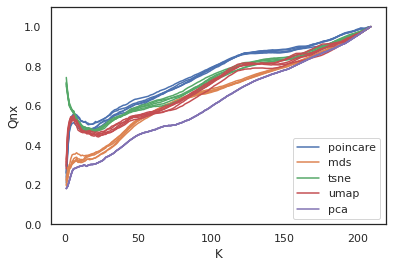

In [79]:
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(range(1,len(xx)+1), xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(range(1,len(xx)+1), xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
plt.savefig("Qnx_global_kinases.pdf")
plt.show()

In [78]:
print("Local")
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.std()))
    
print("Global")   
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.std()))

Local
poincare 0.44, 0.02
mds 0.29, 0.01
tsne 0.72, 0.01
umap 0.45, 0.01
pca 0.23, 0.00
Global
poincare 0.77, 0.01
mds 0.68, 0.00
tsne 0.73, 0.01
umap 0.71, 0.01
pca 0.63, 0.00


In [ ]:
fig = px.strip(df_results, x='method', y='FMS', color = "true_col")
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="Domain"], x='method', y=['corr'])
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="Domain"], x='method', y='Qglobal')
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="Domain"], x='method', y="Qlocal")
fig.show()

### Poincaré distances hyperboliques 

In [ ]:
for cname in ['agglomerative', 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col] != other]
        for name in othersplus:
            df_noothers = df_embedding[df_embedding[true_col] != name]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_poincare"])
    print(scipy.stats.spearmanr(D_raw.ravel(), model.distances.ravel(), axis = 0))

    fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = "clust_poincare",
                                 #second_labels_name = second_labels_name, 
                                 #show_text = show_text,
                                 #labels_text = labels_text,
                                 color_palette = None,
                                 #color_discrete_sequence = px.colors.qualitative.Alphabet,
                                 #color_discrete_map=globin_palette,
                                 #title = title, 
                                 fontsize = 11)
    fig.show()


        #        scores.append(s)
#        titles.append(t)

#for cname in ['spectral', 'agglomerative', 'kmedoids']:
 #       s, t = detect_cluster(model.get_distances(), 
  #                            n_clusters=nc, clustering_name=cname, k=15, distances='raw')
        #scores.append(s)
        #titles.append(t)

### MDS

In [ ]:
X_cosine = pairwise_distances(features,metric='cosine')
X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = 42).fit_transform(X_cosine)
df_embedding["x1_mds"] = X_mds[:,0]
df_embedding["x2_mds"] = X_mds[:,1]

In [ ]:
D = pairwise_distances(X_mds)
print(D.shape)

for cname in ['agglomerative','spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col]!=other]
        for name in othersplus:
            df_noothers = df_embedding[df_embedding[true_col] != name]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_mds"])
    print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding["clust_mds"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

### t-SNE

In [ ]:
X_tsne = TSNE(random_state = 42, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]

In [ ]:
D = pairwise_distances(X_tsne)
print(D.shape)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col]!=other]
        #for name in othersplus:
         #   df_noothers = df_embedding[df_embedding[true_col] != name]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_tsne"])
    print(scipy.stats.spearmanr(D_raw.ravel(), model.distances.ravel(), axis = 0))

    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding["clust_tsne"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

### Raw distances

### UMAP

In [ ]:
X_umap = umap.UMAP(random_state = 42, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]

In [ ]:
D = pairwise_distances(X_umap)
print(D.shape)

for cname in ['agglomerative', 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col]!=other]
        #for name in othersplus:
         #   df_noothers = df_embedding[df_embedding[true_col] != name]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_umap"])
    
    plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding["clust_umap"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

### PCA

In [ ]:
X_pca = KernelPCA(kernel='linear', random_state = 42).fit_transform(features)
df_embedding["x1_pca"] = X_pca[:,0]
df_embedding["x2_pca"] = X_pca[:,1]

In [ ]:
D = pairwise_distances(X_pca)
print(D.shape)


for cname in ['agglomerative', 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    df_noothers = df_embedding[df_embedding[true_col]!=other]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_pca"])
    
    plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding["clust_pca"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()